<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [3]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving IMG_8365.jpeg to IMG_8365.jpeg

Upload Style Image


Saving album.jpg to album.jpg
Content Path: <_io.BytesIO object at 0x7f0c83b31a40>
Style Path: <_io.BytesIO object at 0x7f0c83b31eb8>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg19(pretrained=True).features.eval().cuda()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = ['conv5_3']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
all_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1', 'conv5_3']
content_indeces = [vgg_names.index(name) for name in content_layers]
style_indeces = [vgg_names.index(name) for name in style_layers]
all_indeces = [vgg_names.index(name) for name in all_layers]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
vgg_style = VGGIntermediate(style_indeces)
vgg_content = VGGIntermediate(content_indeces)

vgg_generated = VGGIntermediate(all_indeces)



# Cache the outputs of the content and style layers for their respective images
style_outputs = vgg_style(style_image)
content_outputs = vgg_content(content_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 106MB/s]


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**
* Display the style tensor and content tensor transformed back to an image

**DONE:**

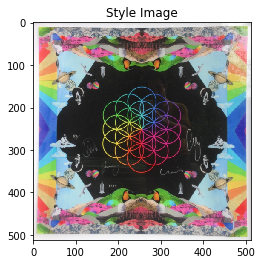

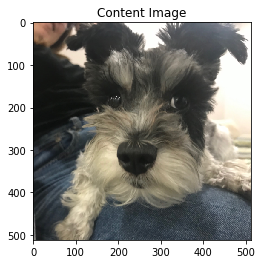

In [8]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


def imshow(tensors, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image    
    num = len(tensors)
    f, axs = plt.subplots(1,num, figsize=(8*num, 8))
    
    for i in range(len(tensors)):
        image = tensors[i].cpu().clone()  # we clone the tensor to not make changes to the original
        image = image.squeeze(0)          # remove the batch dimension
        image = unloader(image)           # transform the image from a tensor to a PIL image so we can show it.

        p = plt.subplot(1,num,i+1)
        p.imshow(image)
        p.axis('off')
        
        if title is not None:             # Display the title if there is one.
            plt.title(title[i])         

    plt.show()
    plt.pause(0.001)                  # pause a bit so that plots are updated


___

### Part 3
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [0]:
def gram_matrix(input):
    b, f, h, w = input.size()  
    features = input.reshape((b * f, h * w))
    gram = torch.mm(features, features.t())
    return gram
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, x):
    return F.mse_loss(x, self.target)

class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target).detach()
  
  def forward(self, x):
    gram = gram_matrix(x)
    return F.mse_loss(gram, self.target)

content_loss_modules = {layer: ContentLoss(content_outputs[layer]) for layer in content_indeces}
style_loss_modules = {layer: StyleLoss(style_outputs[layer]) for layer in style_indeces}


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



epoch 0:
Style Loss : 160207945728.000000 Content Loss: 0.000000

epoch 50:
Style Loss : 17822138368.000000 Content Loss: 18.815184

epoch 100:
Style Loss : 4773582848.000000 Content Loss: 24.761997

epoch 150:
Style Loss : 3253231360.000000 Content Loss: 26.442617



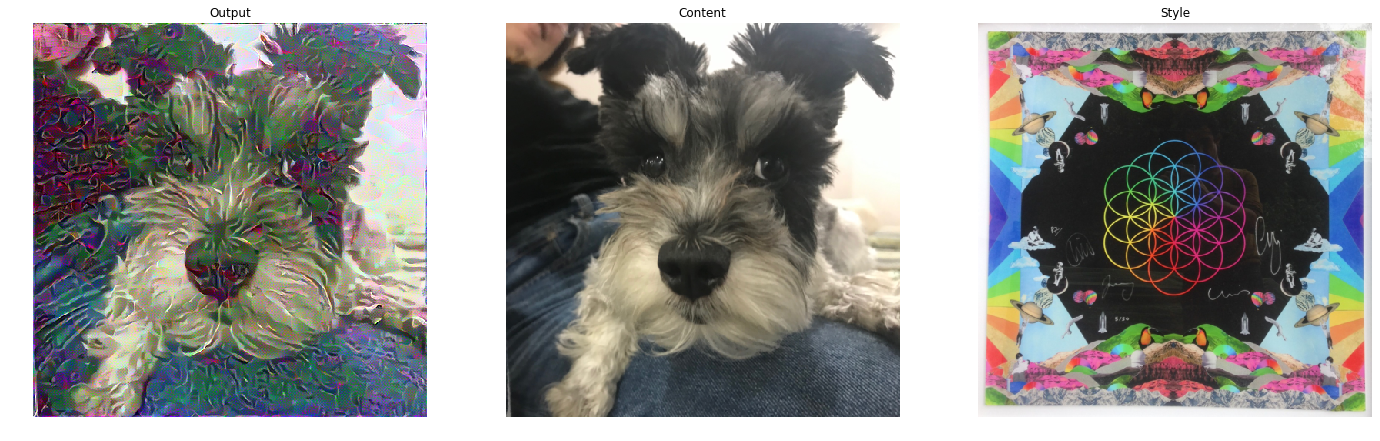

In [13]:
# Start with a copy of the content image
input_image = content_image.clone()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 

optimizer = optim.Adam([input_image.requires_grad_()], lr=0.1)

EPOCHS = 200
w_content = 1
w_style = 1000000000

for epoch in range(EPOCHS):
  optimizer.zero_grad()
  input_image.data.clamp_(0, 1)
  imgs = vgg_generated(input_image)
  content_loss = 0
  for layer in content_indeces:
    content_loss += content_loss_modules[layer](imgs[layer])
    
  style_loss = 0
  for layer in style_indeces:
    style_loss += style_loss_modules[layer](imgs[layer])
  
  loss = content_loss * w_content + style_loss * w_style
  loss.backward()
  optimizer.step()
  if epoch % 50 == 0:
    print("epoch {}:".format(epoch))
    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
        style_loss.item(), content_loss.item()))
    print()

input_image.data.clamp_(0, 1)
imshow([input_image, content_image, style_image] , title=['Output','Content', 'Style'])

### Part 5

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

### Equation (1) on p. 10
 - p and x are the content image and the image being generated, respectively
 - l is the current layer in the network
 - i corresponds to the filter in layer l
 - j corresponds to the position in filter i
 - P is the feature representation of p in the current layer, meaning the output of the current layer for the content image
 - F is the feature representation of x in the current layer, meaning the output of the current layer for the generated image
 
 The equation as a whole is the mean squared error loss between the feature representations of the content image and the feature representation of the current generated image. This is used to determine the loss in terms of content and improve the content quality of the generated image by acting as a distance between the content image and the generated image in terms of content.


### Equation (3) on p. 11
 - i and j are the indeces of the feature maps that are being compared
 - k is the current index inside of each feature map
 - l is the current layer in the network, corresponding to a list of feature maps
 - F just means its the feature map corresponding to i or j
 
 This equation is an inner product, or basically a pointwise multiply followed by a sum over the resulting matrix. Gij corresponds to one position in the final Gram matrix G for that layer, and it produced by multiplying the ith and jth feature maps (or output of the ith and jth filters) together with an innerproduct. If you reshape the feature map to be a vector, you are actually doing dot products between each feature map, which gives you a measure of similarity. So the gram matrix measures similarity over all feature maps.
 
 
### Equation (4) on p. 11
 - l is the current layer of the network
 - i and j correspond to a position in the matrices G and A
 - G is the feature representation of the generated image in the current layer
 - A is the feature representation of the style image in the current layer
 - N is the number of distinct filters/feature maps in the current layer
 - M is the size of each feature map in the current layer, given by the height multiplied by the width of the feature map.
 
 This equation represents the amount that layer l contributes to the total style loss. It is measured similarly to the content loss, but instead of measuring distance between the generated image and the original image, it is measured between the generated image and the gram matrix of the original image.
 
### Equation (5) on p. 11
 - a and x are the style image and the generated image, respectively
 - l is the current layer
 - w is a weighting factor for each layer that shows the contribution of each layer to the total loss. These can actually be adjusted so that you can decide how much you want the style and content images to contribute the generated image.
 - E is the output of equation (4) for layer l
 
 This equation is essentially a weighted sum of the contribution of each layer to the overall style loss. This is used to determine the distance from the original style image to the generated image in terms of style, and to help modify the generated image to fit better.